# CosmoFlow profiling
- 16 Epochs
- Runs on Summit
- Data collected for each rank w/ NSight Systems 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import DataSet
from textwrap import wrap
import seaborn as sns


# Load the data
files = [
    "/ccs/home/mrowan/scratch/ml-performance-benchmark/cosmoflow/summit/results/1_nodes_batchsize_1_j923942/profiling_results/",
    "/ccs/home/mrowan/scratch/ml-performance-benchmark/cosmoflow/summit/results/2_nodes_batchsize_1_j923943/profiling_results/",
    "/ccs/home/mrowan/scratch/ml-performance-benchmark/cosmoflow/summit/results/4_nodes_batchsize_1_j923944/profiling_results/",
    "/ccs/home/mrowan/scratch/ml-performance-benchmark/cosmoflow/summit/results/8_nodes_batchsize_1_j923945/profiling_results/",
    "/ccs/home/mrowan/scratch/ml-performance-benchmark/cosmoflow/summit/results/16_nodes_batchsize_1_j923946/profiling_results/"]

d = DataSet.DataSet()
for f in files:
    d.parseInput(f)

## Plotting preferences

In [11]:
golden = 1.61803398875
figWidth = 5. # inches
figLength = figWidth/golden
figSize1x1 = (figWidth, figLength)

rcParams['font.sans-serif'] = 'Arial'
rcParams['font.family'] = 'sans-serif'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['mathtext.it'] = 'Arial:italic'
rcParams['mathtext.bf'] = 'Arial:bold'
rcParams['axes.labelsize'] = '12'
rcParams['xtick.labelsize'] = '12'
rcParams['ytick.labelsize'] = '12'
rcParams['legend.labelspacing'] = '0.1'
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams['ytick.right'] = True
rcParams['xtick.top'] = True
rcParams['axes.linewidth'] = 2.0
rcParams['xtick.major.size'] = 3.5
rcParams['xtick.major.width'] = 1.5
rcParams['xtick.minor.size'] = 2.5
rcParams['xtick.minor.width'] = 1.0
rcParams['ytick.major.size'] = 3.5
rcParams['ytick.major.width'] = 1.5
rcParams['ytick.minor.size'] = 2.5
rcParams['ytick.minor.width'] = 1.0
rcParams['lines.markersize'] = 7
rcParams['lines.linewidth'] = 1.5

markers1 = np.array(['o', '^', 's', 'x', 'd', 'v'])
markers2 = np.array(['s', 'o', 'x', '*'])
# Other options: Dark2, Pastel1, Pastel2, Accent,
# Set1, Set2, Set3, tab10, tab20, tab20b, tab20c
colors = sns.color_palette('muted') + sns.color_palette('dark',)

## GPU Kernel Time 

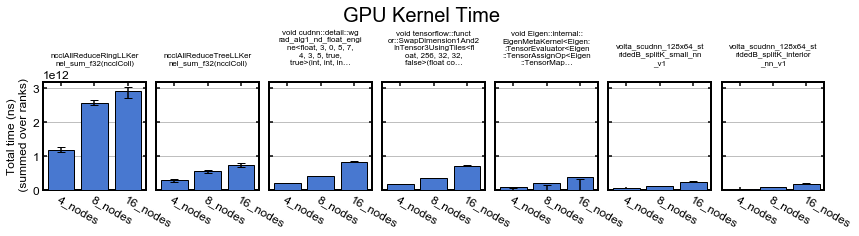

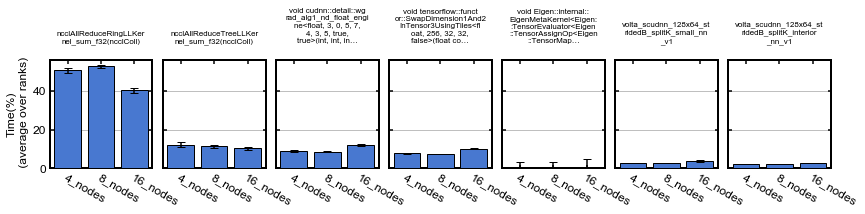

In [9]:
nRoutines = 7
all_nodes = sorted(list(d._hash.keys())[1:],key=lambda x:int(x.replace('_nodes', '')))#
#all_nodes = list(d._hash.keys())[1:]
ranksPerNodeSummit = 6
nRanks = np.array([ranksPerNodeSummit*int(x.split('_')[0]) for x in all_nodes])
# Note 1_node and >1_node case has different routines, so can't compare exactly
expensiveRoutines = d['2_nodes']['r0']['gpukernsum']['Name'][:nRoutines].values

# Compare raw times
fig, axs = plt.subplots(nrows=1, ncols=nRoutines, sharey=True, figsize=(14, 2.))
plt.suptitle('GPU Kernel Time', y=1.4, fontsize=20)
for i, routine in enumerate(expensiveRoutines):
    expensiveRoutineTimesSum = [ np.array( [np.array(d[nodes][r]['gpukernsum'].loc[d[nodes][r]['gpukernsum']['Name'] == routine]['Total Time (ns)'])
                                             for r in d[nodes].keys()] ).sum() for nodes in all_nodes]
    expensiveRoutineTimesMin = [ np.array( [np.array(d[nodes][r]['gpukernsum'].loc[d[nodes][r]['gpukernsum']['Name'] == routine]['Total Time (ns)'])
                                             for r in d[nodes].keys()] ).min() for nodes in all_nodes] 
    expensiveRoutineTimesMax = [ np.array( [np.array(d[nodes][r]['gpukernsum'].loc[d[nodes][r]['gpukernsum']['Name'] == routine]['Total Time (ns)'])
                                             for r in d[nodes].keys()] ).max() for nodes in all_nodes]
    yerrs = np.array([err for err in zip(np.array(expensiveRoutineTimesSum) - nRanks*np.array(expensiveRoutineTimesMin), 
                                         nRanks*np.array(expensiveRoutineTimesMax) - np.array(expensiveRoutineTimesSum))]).T
    
    plt.sca(axs.flatten()[i])
    plt.gca().set_title("\n".join(wrap(routine, 22)), fontsize='8')
    plt.gca().title.set_y(1.1)
    plt.bar(all_nodes, expensiveRoutineTimesSum, color=colors[0], 
            yerr=yerrs, edgecolor='k',
           capsize=4, zorder=5, ecolor='k')
    plt.gca().yaxis.grid(True)

    plt.xticks(rotation=-30, ha="left", rotation_mode="anchor")
    if i==0: plt.ylabel('Total time (ns)\n (summed over ranks)')
    
fig.subplots_adjust(wspace=0.1)
plt.savefig('figs/GPU_Kernel_Time_ns.png', dpi=150, bbox_inches='tight')

# Compare % times
fig, axs = plt.subplots(nrows=1, ncols=nRoutines, sharey=True, figsize=(14, 2.))
for i, routine in enumerate(expensiveRoutines):
    expensiveRoutineTimesSum = [ np.array( [np.array(d[nodes][r]['gpukernsum'].loc[d[nodes][r]['gpukernsum']['Name'] == routine]['Time(%)'])
                                             for r in d[nodes].keys()] ).mean() for nodes in all_nodes]
    expensiveRoutineTimesMin = [ np.array( [np.array(d[nodes][r]['gpukernsum'].loc[d[nodes][r]['gpukernsum']['Name'] == routine]['Time(%)'])
                                             for r in d[nodes].keys()] ).min() for nodes in all_nodes] 
    expensiveRoutineTimesMax = [ np.array( [np.array(d[nodes][r]['gpukernsum'].loc[d[nodes][r]['gpukernsum']['Name'] == routine]['Time(%)'])
                                             for r in d[nodes].keys()] ).max() for nodes in all_nodes]
    yerrs = np.array([err for err in zip(np.array(expensiveRoutineTimesSum) - np.array(expensiveRoutineTimesMin), 
                                         np.array(expensiveRoutineTimesMax) - np.array(expensiveRoutineTimesSum))]).T
    
    plt.sca(axs.flatten()[i])
    plt.gca().set_title("\n".join(wrap(routine, 22)), fontsize='8')
    plt.gca().title.set_y(1.1)
    plt.bar(all_nodes, expensiveRoutineTimesSum, color=colors[0], 
            yerr=yerrs, edgecolor='k',
           capsize=4, zorder=5, ecolor='k')
    plt.gca().yaxis.grid(True)

    plt.xticks(rotation=-30, ha="left", rotation_mode="anchor")
    if i==0: plt.ylabel('Time(%)\n (average over ranks)')
    
fig.subplots_adjust(wspace=0.1)
plt.savefig('figs/GPU_Kernel_Time_Percent.png', dpi=150, bbox_inches='tight')

## GPU Mem Time

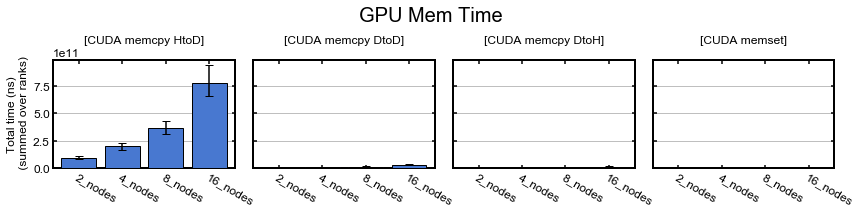

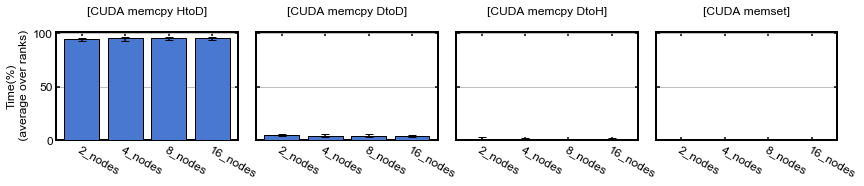

In [4]:
all_nodes = sorted(list(d._hash.keys())[1:],key=lambda x:int(x.replace('_nodes', '')))
ranksPerNodeSummit = 6
nRanks = np.array([ranksPerNodeSummit*int(x.split('_')[0]) for x in all_nodes])
expensiveRoutines = d['1_nodes']['r0']['gpumemtimesum']['Operation'].values

# Compare raw times
fig, axs = plt.subplots(nrows=1, ncols=len(expensiveRoutines), sharey=True, figsize=(14, 2.))
plt.suptitle('GPU Mem Time', y=1.25, fontsize=20)
for i, routine in enumerate(expensiveRoutines):
    expensiveRoutineTimesSum = [ np.array( [np.array(d[nodes][r]['gpumemtimesum'].loc[d[nodes][r]['gpumemtimesum']['Operation'] == routine]['Total Time (ns)'])
                                             for r in d[nodes].keys()] ).sum() for nodes in all_nodes]
    expensiveRoutineTimesMin = [ np.array( [np.array(d[nodes][r]['gpumemtimesum'].loc[d[nodes][r]['gpumemtimesum']['Operation'] == routine]['Total Time (ns)'])
                                             for r in d[nodes].keys()] ).min() for nodes in all_nodes] 
    expensiveRoutineTimesMax = [ np.array( [np.array(d[nodes][r]['gpumemtimesum'].loc[d[nodes][r]['gpumemtimesum']['Operation'] == routine]['Total Time (ns)'])
                                             for r in d[nodes].keys()] ).max() for nodes in all_nodes]
    yerrs = np.array([err for err in zip(np.array(expensiveRoutineTimesSum) - nRanks*np.array(expensiveRoutineTimesMin), 
                                         nRanks*np.array(expensiveRoutineTimesMax) - np.array(expensiveRoutineTimesSum))]).T
    
    plt.sca(axs.flatten()[i])
    plt.gca().set_title("\n".join(wrap(routine, 22)))
    plt.gca().title.set_y(1.1)
    plt.bar(all_nodes, expensiveRoutineTimesSum, color=colors[0], 
            yerr=yerrs, edgecolor='k',
           capsize=4, zorder=5, ecolor='k')
    plt.gca().yaxis.grid(True)

    plt.xticks(rotation=-30, ha="left", rotation_mode="anchor")
    if i==0: plt.ylabel('Total time (ns)\n (summed over ranks)')
    
fig.subplots_adjust(wspace=0.1)
plt.savefig('figs/GPU_Mem_Time_ns.png', dpi=150, bbox_inches='tight')

# Compare % times
fig, axs = plt.subplots(nrows=1, ncols=len(expensiveRoutines), sharey=True, figsize=(14, 2.))
for i, routine in enumerate(expensiveRoutines):
    expensiveRoutineTimesSum = [ np.array( [np.array(d[nodes][r]['gpumemtimesum'].loc[d[nodes][r]['gpumemtimesum']['Operation'] == routine]['Time(%)'])
                                             for r in d[nodes].keys()] ).mean() for nodes in all_nodes]
    expensiveRoutineTimesMin = [ np.array( [np.array(d[nodes][r]['gpumemtimesum'].loc[d[nodes][r]['gpumemtimesum']['Operation'] == routine]['Time(%)'])
                                             for r in d[nodes].keys()] ).min() for nodes in all_nodes] 
    expensiveRoutineTimesMax = [ np.array( [np.array(d[nodes][r]['gpumemtimesum'].loc[d[nodes][r]['gpumemtimesum']['Operation'] == routine]['Time(%)'])
                                             for r in d[nodes].keys()] ).max() for nodes in all_nodes]
    yerrs = np.array([err for err in zip(np.array(expensiveRoutineTimesSum) - np.array(expensiveRoutineTimesMin), 
                                         np.array(expensiveRoutineTimesMax) - np.array(expensiveRoutineTimesSum))]).T
    
    plt.sca(axs.flatten()[i])
    plt.gca().set_title("\n".join(wrap(routine, 22)))
    plt.gca().title.set_y(1.1)
    plt.bar(all_nodes, expensiveRoutineTimesSum, color=colors[0], 
            yerr=yerrs, edgecolor='k',
           capsize=4, zorder=5, ecolor='k')
    plt.gca().yaxis.grid(True)

    plt.xticks(rotation=-30, ha="left", rotation_mode="anchor")
    if i==0: plt.ylabel('Time(%)\n (average over ranks)')
    
fig.subplots_adjust(wspace=0.1)
plt.savefig('figs/GPU_Mem_Time_Percent.png', dpi=150, bbox_inches='tight')

## CUDA API Time

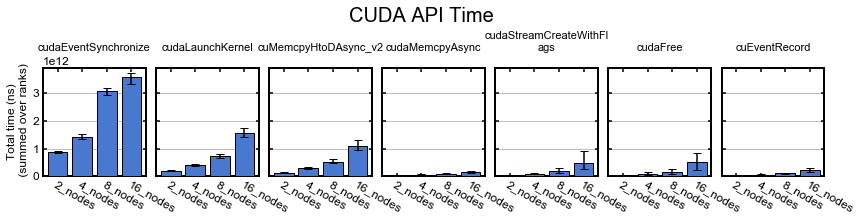

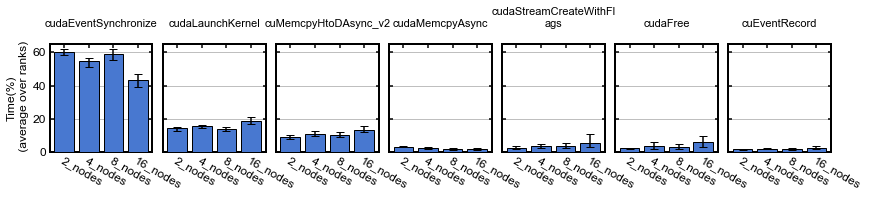

In [5]:
nRoutines = 7
all_nodes = sorted(list(d._hash.keys())[1:],key=lambda x:int(x.replace('_nodes', '')))#
ranksPerNodeSummit = 6
nRanks = np.array([ranksPerNodeSummit*int(x.split('_')[0]) for x in all_nodes])
# Note 1_node and >1_node case has different routines, so can't compare exactly
expensiveRoutines = d['1_nodes']['r0']['cudaapisum']['Name'][:nRoutines].values

# Compare raw times
fig, axs = plt.subplots(nrows=1, ncols=nRoutines, sharey=True, figsize=(14, 2.))
plt.suptitle('CUDA API Time', y=1.3, fontsize=20)
for i, routine in enumerate(expensiveRoutines):
    expensiveRoutineTimesSum = [ np.array( [np.array(d[nodes][r]['cudaapisum'].loc[d[nodes][r]['cudaapisum']['Name'] == routine]['Total Time (ns)'])
                                             for r in d[nodes].keys()] ).sum() for nodes in all_nodes]
    expensiveRoutineTimesMin = [ np.array( [np.array(d[nodes][r]['cudaapisum'].loc[d[nodes][r]['cudaapisum']['Name'] == routine]['Total Time (ns)'])
                                             for r in d[nodes].keys()] ).min() for nodes in all_nodes] 
    expensiveRoutineTimesMax = [ np.array( [np.array(d[nodes][r]['cudaapisum'].loc[d[nodes][r]['cudaapisum']['Name'] == routine]['Total Time (ns)'])
                                             for r in d[nodes].keys()] ).max() for nodes in all_nodes]
    yerrs = np.array([err for err in zip(np.array(expensiveRoutineTimesSum) - nRanks*np.array(expensiveRoutineTimesMin), 
                                         nRanks*np.array(expensiveRoutineTimesMax) - np.array(expensiveRoutineTimesSum))]).T
    
    plt.sca(axs.flatten()[i])
    plt.gca().set_title("\n".join(wrap(routine, 22)), fontsize='11')
    plt.gca().title.set_y(1.1)
    plt.bar(all_nodes, expensiveRoutineTimesSum, color=colors[0], 
            yerr=yerrs, edgecolor='k',
           capsize=4, zorder=5, ecolor='k')
    plt.gca().yaxis.grid(True)

    plt.xticks(rotation=-30, ha="left", rotation_mode="anchor")
    if i==0: plt.ylabel('Total time (ns)\n (summed over ranks)')
    
fig.subplots_adjust(wspace=0.1)
plt.savefig('figs/CUDA_API_Time_ns.png', dpi=150, bbox_inches='tight')

# Compare % times
fig, axs = plt.subplots(nrows=1, ncols=nRoutines, sharey=True, figsize=(14, 2.))
for i, routine in enumerate(expensiveRoutines):
    expensiveRoutineTimesSum = [ np.array( [np.array(d[nodes][r]['cudaapisum'].loc[d[nodes][r]['cudaapisum']['Name'] == routine]['Time(%)'])
                                             for r in d[nodes].keys()] ).mean() for nodes in all_nodes]
    expensiveRoutineTimesMin = [ np.array( [np.array(d[nodes][r]['cudaapisum'].loc[d[nodes][r]['cudaapisum']['Name'] == routine]['Time(%)'])
                                             for r in d[nodes].keys()] ).min() for nodes in all_nodes] 
    expensiveRoutineTimesMax = [ np.array( [np.array(d[nodes][r]['cudaapisum'].loc[d[nodes][r]['cudaapisum']['Name'] == routine]['Time(%)'])
                                             for r in d[nodes].keys()] ).max() for nodes in all_nodes]
    yerrs = np.array([err for err in zip(np.array(expensiveRoutineTimesSum) - np.array(expensiveRoutineTimesMin), 
                                         np.array(expensiveRoutineTimesMax) - np.array(expensiveRoutineTimesSum))]).T
    
    plt.sca(axs.flatten()[i])
    plt.gca().set_title("\n".join(wrap(routine, 22)), fontsize='11')
    plt.gca().title.set_y(1.1)
    plt.bar(all_nodes, expensiveRoutineTimesSum, color=colors[0], 
            yerr=yerrs, edgecolor='k',
           capsize=4, zorder=5, ecolor='k')
    plt.gca().yaxis.grid(True)

    plt.xticks(rotation=-30, ha="left", rotation_mode="anchor")
    if i==0: plt.ylabel('Time(%)\n (average over ranks)')
    
fig.subplots_adjust(wspace=0.1)
plt.savefig('figs/CUDA_API_Time_Percent.png', dpi=150, bbox_inches='tight')

## GPU Kernel Time vs. GPU Mem Time for nodes

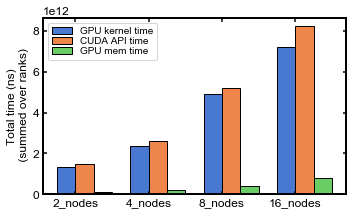

In [6]:
all_nodes = sorted(list(d._hash.keys())[1:],key=lambda x:int(x.replace('_nodes', '')))#

#ranksPerNodeSummit = 6
#nRanks = np.array([ranksPerNodeSummit*int(x.split('_')[0]) for x in all_nodes])
gpukerntime = [ sum([d[nodes][r]['gpukernsum']['Total Time (ns)'].sum() 
                    for r in d[nodes].keys()]) for nodes in all_nodes]
gpumemtime = [ sum([d[nodes][r]['gpumemtimesum']['Total Time (ns)'].sum() 
                    for r in d[nodes].keys()]) for nodes in all_nodes]
cudaapitime = [ sum([d[nodes][r]['cudaapisum']['Total Time (ns)'].sum() 
                    for r in d[nodes].keys()]) for nodes in all_nodes]
      
plt.ion()
plt.figure(figsize=figSize1x1)
# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = gpukerntime
bars2 = cudaapitime
bars3 = gpumemtime
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color=colors[0], width=barWidth, edgecolor='k', label='GPU kernel time')
plt.bar(r2, bars2, color=colors[1], width=barWidth, edgecolor='k', label='CUDA API time')
plt.bar(r3, bars3, color=colors[2], width=barWidth, edgecolor='k', label='GPU mem time')
     
plt.ylabel('Total time (ns)\n (summed over ranks)')
#plt.ylim(0, 3.2e12)
plt.xticks([r + 0.5*barWidth for r in range(len(bars1))], all_nodes);

plt.legend(loc=2)
plt.tight_layout()
plt.savefig('figs/Time_vs_Nodes.png', dpi=150, bbox_inches='tight')